In [98]:
import numpy as np
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder
from datetime import date
from datetime import datetime

from scipy.sparse import csr_matrix

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

In [64]:
df = pd.read_csv('edzd_trans_data.csv')
# print type of each column
for col in df.columns:
    print("Type of column", col, "is", df[col].dtype)

Type of column transaction_id is object
Type of column sales_datetime is object
Type of column customer_id is object
Type of column product_id is object
Type of column quantity is float64
Type of column price is float64
Type of column category_id is int64
Type of column parent_id is int64
Type of column store_id is int64
Type of column department_id is int64
Type of column salesperson_id is int64


In [65]:
# change the type of product_id to int and number them from 1 to number of different product_ids
df['product_id'] = df['product_id'].astype('category')
df['product_id'] = df['product_id'].cat.codes

# change the type of transaction_id to int and number them from 1 to number of different transaction_ids
df['transaction_id'] = df['transaction_id'].astype('category')
df['transaction_id'] = df['transaction_id'].cat.codes

# df['customer_id'] = df['customer_id'].astype('string')

for col in df.columns:
    print("Type of column", col, "is", df[col].dtype)

Type of column transaction_id is int32
Type of column sales_datetime is object
Type of column customer_id is object
Type of column product_id is int32
Type of column quantity is float64
Type of column price is float64
Type of column category_id is int64
Type of column parent_id is int64
Type of column store_id is int64
Type of column department_id is int64
Type of column salesperson_id is int64


In [4]:
print(df.head())
print(df.shape)

   transaction_id       sales_datetime customer_id  product_id  quantity  \
0          680577  2011-01-01 09:04:00          -1         157       1.0   
1         3148654  2011-01-01 09:04:00          -1       43930       1.0   
2         3148654  2011-01-01 09:04:00          -1       12666       1.0   
3          651357  2011-01-01 09:08:00          -1       39576       1.0   
4          651357  2011-01-01 09:08:00          -1       44343       1.0   

   price  category_id  parent_id  store_id  department_id  salesperson_id  
0   13.5          208         29        18              2             108  
1    6.5          179         30        17              2             108  
2    6.5          179         30        17              2             108  
3   10.5          175         29         1              2             108  
4   17.5          208         29         1              2             108  
(8159536, 11)


## next

In [5]:
# Create a sparse matrix of the data group it by transaction_id and product_id
my_basket = csr_matrix(
    (df['quantity'], (df['transaction_id'], df['product_id'])))

# change all positive values to 1 and all negative values to 0
my_basket.data = np.where(my_basket.data > 0, 1, 0)

# Create a dataframe of the sparse matrix
my_basket = pd.DataFrame.sparse.from_spmatrix(my_basket)
print(my_basket.head())

   0      1      2      3      4      5      6      7      8      9      ...  \
0      0      0      0      0      0      0      0      0      0      0  ...   
1      0      0      0      0      0      0      0      0      0      0  ...   
2      0      0      0      0      0      0      0      0      0      0  ...   
3      0      0      0      0      0      0      0      0      0      0  ...   
4      0      0      0      0      0      0      0      0      0      0  ...   

   94092  94093  94094  94095  94096  94097  94098  94099  94100  94101  
0      0      0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0      0      0  

[5 rows x 94102 columns]


In [6]:
my_basket_sets = my_basket

# print(my_basket_sets.head())

# change all values to boolean
my_basket_sets = my_basket_sets.astype(bool)

print(my_basket_sets.head())

/tmp/ipykernel_44411/1440229732.py:6: FutureWarning: The behavior of .astype from SparseDtype to a non-sparse dtype is deprecated. In a future version, this will return a non-sparse array with the requested dtype. To retain the old behavior, use `obj.astype(SparseDtype(dtype))`
  my_basket_sets = my_basket_sets.astype(bool)


   0      1      2      3      4      5      6      7      8      9      ...  \
0  False  False  False  False  False  False  False  False  False  False  ...   
1  False  False  False  False  False  False  False  False  False  False  ...   
2  False  False  False  False  False  False  False  False  False  False  ...   
3  False  False  False  False  False  False  False  False  False  False  ...   
4  False  False  False  False  False  False  False  False  False  False  ...   

   94092  94093  94094  94095  94096  94097  94098  94099  94100  94101  
0  False  False  False  False  False  False  False  False  False  False  
1  False  False  False  False  False  False  False  False  False  False  
2  False  False  False  False  False  False  False  False  False  False  
3  False  False  False  False  False  False  False  False  False  False  
4  False  False  False  False  False  False  False  False  False  False  

[5 rows x 94102 columns]


In [7]:
# get date from string
def get_date(string):
    return datetime.strptime(string, '%Y-%m-%d %H:%M:%S').date()

# number of days over which data was collected
delta = get_date(max(df['sales_datetime'])) - get_date(min(df['sales_datetime']))
days_count = delta.days
print(days_count)

# number of transactions in our data
transactions_count = df.shape[0]

1369


In [8]:
# frequent = appears at least in 20 transactions in a day
min_support = 20 * days_count / transactions_count

my_frequent_itemsets = apriori(my_basket_sets, min_support=min_support)

print("there are " + str(my_frequent_itemsets.shape[0]) + " frequent itemsets")

there are 37 frequent itemsets


In [ ]:
# frequent = appears at least in 3 transactions in a day
min_support = 3 * days_count / transactions_count

my_frequent_itemsets = fpgrowth(my_basket_sets, min_support=min_support)

print("there are " + str(my_frequent_itemsets.shape[0]) + " frequent itemsets")

## different way of getting the sparse matrix - by using TransactionEncoder

In [ ]:
df_grouped = df.groupby('transaction_id')['product_id'].apply(list)
dataset = df_grouped.tolist()
print(dataset[:5])

In [ ]:
te = TransactionEncoder()
fitted = te.fit(dataset)
te_ary = fitted.transform(dataset, sparse=True)
my_basket = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)
print(my_basket.head())

In [ ]:
# frequent = appears at least in 30 transactions in a day
min_support = 30 * days_count / transactions_count

my_frequent_itemsets = apriori(my_basket, min_support=min_support)

print("there are " + str(my_frequent_itemsets.shape[0]) + " frequent itemsets")

In [ ]:
# frequent = appears at least in 3 transactions in a day
min_support = 3 * days_count / transactions_count

my_frequent_itemsets = fpgrowth(my_basket, min_support=min_support)

print("there are " + str(my_frequent_itemsets.shape[0]) + " frequent itemsets")

In [ ]:
print(my_frequent_itemsets)

## association rules

In [ ]:
#only confidence

my_association_rules = association_rules(my_frequent_itemsets, metric="confidence", min_threshold=0.7)

print("there are " + str(my_association_rules.shape[0]) + " association rules")
print(my_association_rules)
# 10 rules for 893 frequent itemsets
# 0 for 37 :(

In [ ]:
#only lift

my_association_rules = association_rules(my_frequent_itemsets, metric="lift", min_threshold=1.2)

print("there are " + str(my_association_rules.shape[0]) + " association rules")
print(my_association_rules)
# 100 rules for 893 frequent itemsets

In [ ]:
# antecedent_len >= 2, lift & confidence
 
my_association_rules["antecedent_len"] = my_association_rules["antecedents"].apply(lambda x: len(x))

my_association_rules = my_association_rules[ (my_association_rules['antecedent_len'] >= 2) &
                                             (my_association_rules['confidence'] > 0.75) &
                                             (my_association_rules['lift'] > 1.2) ]

print(my_association_rules)

In [ ]:
my_association_rules["antecedent_len"] = my_association_rules["antecedents"].apply(lambda x: len(x))

my_association_rules = my_association_rules[ (my_association_rules['antecedent_len'] >= 1) &
                                             (my_association_rules['confidence'] > 0.75) &
                                             (my_association_rules['lift'] > 1.2) ]

print(my_association_rules)

In [ ]:
# jakie warto dać wykresuchy?

# ile dostajemy frequent item sets w zależności od min support?
# to byłby taki wykres + dyskusja o tym jaki support ma sens względem rozmiaru danych i okresu czasu, z którego są dane

# ile dostajemy association rules w zależności od confidence, support, lift? (3 wykresy wow)


In [ ]:
#support a rozmiar danych i okres czasu, z którego są dane


# Customer analysis

In [ ]:
# algorytmy do data clustering:
# - k-means
# - u map
# - dbscan

## Data clustering

In [83]:
# data should always be
# [[customer_id 1, sth related to customer 1, ...], [customer_id 2, sth related to customer 2, ...], ...]

# filter out customer_id = -1
df_filtered = df[df['customer_id'] != '-1']

# change customed_id to numeric
le = LabelEncoder()
df_filtered['customer_id'] = le.fit_transform(df_filtered['customer_id'])
# df_filtered = pd.get_dummies(df_filtered, columns=['customer_id'])

print(df_filtered)

         transaction_id       sales_datetime  customer_id  product_id  \
6789             501717  2011-01-03 10:06:00        92354       26838   
7478            2418844  2011-01-03 12:01:00       113131       44520   
7479            2418844  2011-01-03 12:01:00       113131       57544   
8581            3704341  2011-01-03 13:49:00         2419       27992   
8582            3704341  2011-01-03 13:49:00         2419       27992   
...                 ...                  ...          ...         ...   
8159528         3026494  2014-10-01 20:51:00       119861       31054   
8159529          797946  2014-10-01 20:54:00         7589       51188   
8159530          797946  2014-10-01 20:54:00         7589       44626   
8159532          476485  2014-10-01 20:56:00        61463       39927   
8159533          476485  2014-10-01 20:56:00        61463       30249   

         quantity    price  category_id  parent_id  store_id  department_id  \
6789          1.0  35.0000          110     

/tmp/ipykernel_44411/2580210367.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['customer_id'] = le.fit_transform(df_filtered['customer_id'])


In [84]:
# use the product_id, quantity, price, and category_id columns to cluster customers into
# groups of those who have similar purchasing habits
df_shortened = df_filtered[['product_id', 'quantity', 'price', 'category_id', 'customer_id']]

# group by customer_id and sum the quantities and prices
df_grouped = df_shortened.groupby('customer_id').sum()
data = df_grouped.reset_index().values.tolist()
print(data[:5])
print(len(data))

[[0.0, 639006.0, 9.0, 252.99, 2371.0], [1.0, 314060.0, 8.0, 20.5, 1663.0], [2.0, 1962510.0, 32.042699999999996, 410.8, 10555.0], [3.0, 396.0, 1.0, 10.0, 235.0], [4.0, 231356.0, 6.0, 60.87, 1864.0]]
204441


In [88]:
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    sse.append(kmeans.inertia_)

/home/zosia/Dokumenty/DZD/Transaction-data/.venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/zosia/Dokumenty/DZD/Transaction-data/.venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/zosia/Dokumenty/DZD/Transaction-data/.venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/zosia/Dokumenty/DZD/Transaction-data/.venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4

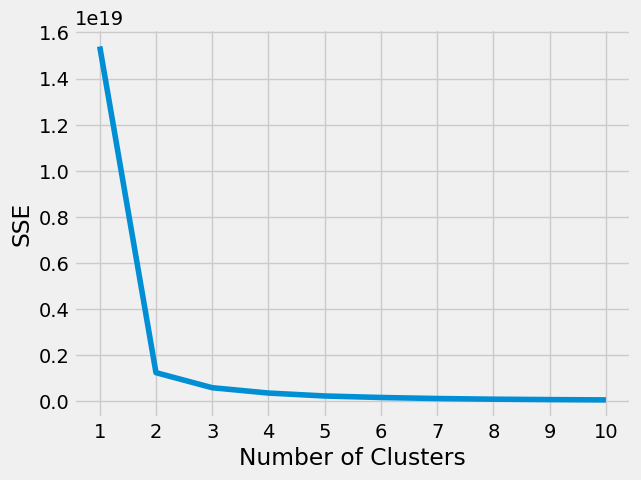

In [89]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [92]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")

In [93]:
kl.elbow

2

In [97]:
# xd to się nigdy nie kończy mielić unlucky
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice we start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    score = silhouette_score(data, kmeans.labels_)
    silhouette_coefficients.append(score)

/home/zosia/Dokumenty/DZD/Transaction-data/.venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [104]:
# ten się nie kończy
# Instantiate k-means algorithm
kmeans = KMeans(n_clusters=2)

# Fit the algorithm to the features
kmeans.fit(data)

# Compute the silhouette scores for this algorithm
kmeans_silhouette = silhouette_score(data, kmeans.labels_).round(2)

/home/zosia/Dokumenty/DZD/Transaction-data/.venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [103]:
# a ten wybombia jakiś błąd, może od złego eps? bo on chyba powinien być na podstawie tych
# silhouette_coefficients, które też się nie kończą
# Instantiate dbscan algorithm
dbscan = DBSCAN(eps=0.3)

# Fit the algorithm to the features
dbscan.fit(data)

# Compute the silhouette scores for this algorithm
dbscan_silhouette = silhouette_score(data, dbscan.labels_).round(2)

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)